# **Predicting Avalanches Danger Rating**

### **Project Description**
Avalanche centers issue a daily avalanche danger rating. The rating can be low, moderate, considerable, high, or extreme. Meteorological events are by far the largest contributer to avalanche conditions. This project aims to predict these danger ratings.
### **Dataset**
Using data collected from MesoWest, I import measurements from the Raymer weather station within the Jackson Hole Mountain Resort ski area. This station has the most consistent data. See below for a list of measurements and units.

Wind Speed: m/s

Wind Direction: degree or cardinal

Temp/Dew Point: celsius

Snow Depth/Interval: mm

Relative Humidity: %

## **Import Data**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd '/content/drive/MyDrive/Avalanche'

/content/drive/MyDrive/Avalanche


In [3]:
!ls

JHB.2021-01-09.csv    JHR.2021-01-09.csv  label_data.csv
JHMWY.2021-01-09.csv  JHS.2021-01-09.csv


In [4]:
import pandas as pd
import numpy as np

r_col=['station','date_time','air_temp','r_humidity','wind_speed','wind_deg','wind_gust','snow_depth','snow_interval','dew_point','wind_cardinal']
df_JHR=pd.read_csv('JHR.2021-01-09.csv',names=r_col,skiprows=12)

df_label=pd.read_csv('label_data.csv')

### **label_data.csv**

label_data.csv is imported above as a file I saved to my local drive after crawling the Bridger Teton Avalanche Center's website for historical archives of avalanche danger all the way back to 1999-11-23. This runtime took around 10 minutes so I took this strategy in order to avoid running this code block everytime. The code for crawling jhavalanche.org (Bridger Teton Avalanche Center) is commented out in the code block below. 

From 1999-2012 the danger rating can be easily scraped. From 2012-2020 the danger ratings are in a preloaded gif. Since there are 5**6 possible danger rating gif's, this presents a challenge. Luckily, I discovered a 'printable version' of each archive with the date in the url and the danger rating in a table format! This makes it easily scrapable except for one unfortunate problem, the rating are transcribed incorretly from the 'regular version' to the 'printable version.' If the danger is 2 in the morning but 3 in the afternoon, the 'printable version' shows 3 for both am and pm. This is fine since the danger always trends more dangerous intra-day, never less dangerous. The model will be forced to be more conservative (predict higher danger on average) which is desirable for this problem.

In [5]:
# import requests
# from bs4 import BeautifulSoup
# import re

# def extract_danger(url):
#   page=requests.get(url)
#   soup=BeautifulSoup(page.content,'html.parser')
#   if len(soup.find_all("table", { "class" : "responsive-card-table unstriped" }))>1:      #this should handle archive being found
#     danger_table=soup.find_all("table", { "class" : "responsive-card-table unstriped" })[1].find('tbody')
#     high_elev_row=danger_table.find_all('tr')[0]
#     cell=high_elev_row.find_all('td')
#     am_danger=cell[1].text
#     pm_danger=cell[2].text
#     am_danger_str=re.findall('\w+', am_danger)[-1]      #if rating is mixed like low/moderate...choose more dangerous label
#     pm_danger_str=re.findall('\w+', pm_danger)[-1]
#     danger_str=['LOW','MODERATE','CONSIDERABLE','HIGH','EXTREME','AVAILABLE','RATING']    #last two are 'not available' or 'no rating'
#     am_danger_ord=danger_str.index(am_danger_str)+1     #code the rating on a scale from 1-5
#     pm_danger_ord=danger_str.index(pm_danger_str)+1
#     return am_danger_ord,pm_danger_ord
#   else:
#     return 'archive not found'


# unique_dates=df_JHR_proc.index.map(lambda t: t.date()).unique()
# target_labels={}
# base_url='http://jhavalanche.org/viewTeton?data_date={}-{}-{}&template=teton_print.tpl.php'
# for u in unique_dates:
#   ratings=extract_danger(base_url.format(u.year,u.month,u.day))
#   target_labels[u]=ratings

# from google.colab import files
# label_df.T.to_csv('label_data.csv')
# files.download("label_data.csv")

## **Data Cleaning**

In [6]:
#Convert to time series
df_JHR.index=pd.to_datetime(df_JHR['date_time'])
df_JHR.sort_index(inplace=True)
df_JHR.drop(['date_time','station'],inplace=True,axis=1)

#The values ['archive not found',6, or 7] need to be replaced with null. Only keep the pm danger rating. Convert to time series.
df_label.replace('archive not found',np.nan,inplace=True)
label_cols=['date_time','am','danger_rating']
df_label.columns=label_cols
df_label['danger_rating']=df_label['danger_rating'].astype(float)
df_label.index=pd.to_datetime(df_label['date_time'])
df_label.drop(['date_time','am'],inplace=True,axis=1)
df_label=df_label.replace(7,np.nan).replace(6,np.nan)

#Make indices compatible and join the two DataFrames. Finally, interpolate all data.
df_label.index=df_label.index.tz_localize(tz='UTC')
df_JHR=df_JHR.join(df_label)
df_JHR=df_JHR.interpolate().bfill().ffill()

## **Exploratory Data Analysis**

In [7]:
df_JHR.head(10)

,air_temp,r_humidity,wind_speed,wind_deg,wind_gust,snow_depth,snow_interval,dew_point,wind_cardinal,danger_rating
date_time,,,,,,,,,,
1999-11-23 00:00:00+00:00,-12.78,76.0,9.83,330.0,13.84,5130.8,76.2,-16.17,NNW,2.0
1999-11-23 00:15:00+00:00,-13.33,75.0,9.83,328.0,12.96,5130.8,76.2,-16.86,NNW,2.0
1999-11-23 00:30:00+00:00,-13.33,74.0,9.41,330.0,12.50,5130.8,76.2,-17.02,NNW,2.0
1999-11-23 00:45:00+00:00,-13.33,75.0,7.15,326.0,10.29,5130.8,76.2,-16.86,NW,2.0
1999-11-23 01:00:00+00:00,-13.33,77.0,7.15,330.0,10.29,5130.8,76.2,-16.54,NNW,2.0
1999-11-23 01:15:00+00:00,-13.33,76.0,6.69,328.0,10.75,5130.8,76.2,-16.70,NNW,2.0
1999-11-23 01:30:00+00:00,-13.33,76.0,5.81,329.0,8.95,5130.8,76.2,-16.70,NNW,2.0
1999-11-23 01:45:00+00:00,-13.33,77.0,4.48,332.0,7.15,5130.8,76.2,-16.54,NNW,2.0
1999-11-23 02:00:00+00:00,-13.33,76.0,2.68,323.0,6.28,5130.8,76.2,-16.70,NW,2.0


In [8]:
df_JHR.describe()

,air_temp,r_humidity,wind_speed,wind_deg,wind_gust,snow_depth,snow_interval,dew_point,danger_rating
count,508924.000000,508924.000000,508924.000000,508924.000000,508924.000000,508924.000000,508924.000000,508924.000000,508924.000000
mean,-2.922184,67.294883,3.694028,223.016919,7.043978,1971.633650,161.455105,-9.388062,2.043565
std,8.743078,23.690188,2.930820,92.942207,5.087039,1542.416584,367.429562,6.928192,0.746826
min,-52.780000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-64.000000,1.000000
25%,-9.440000,47.000000,1.800000,168.000000,4.020000,787.400000,0.000000,-13.670000,1.486285
50%,-4.440000,73.000000,3.389188,254.595188,6.635868,1803.400000,0.000000,-8.890000,2.000000
75%,2.220000,88.000000,4.920000,300.000000,8.940000,2565.400000,106.176746,-4.670000,2.526846
max,53.890000,100.000000,89.850000,360.000000,98.790000,12623.800000,3810.000000,15.560000,5.000000


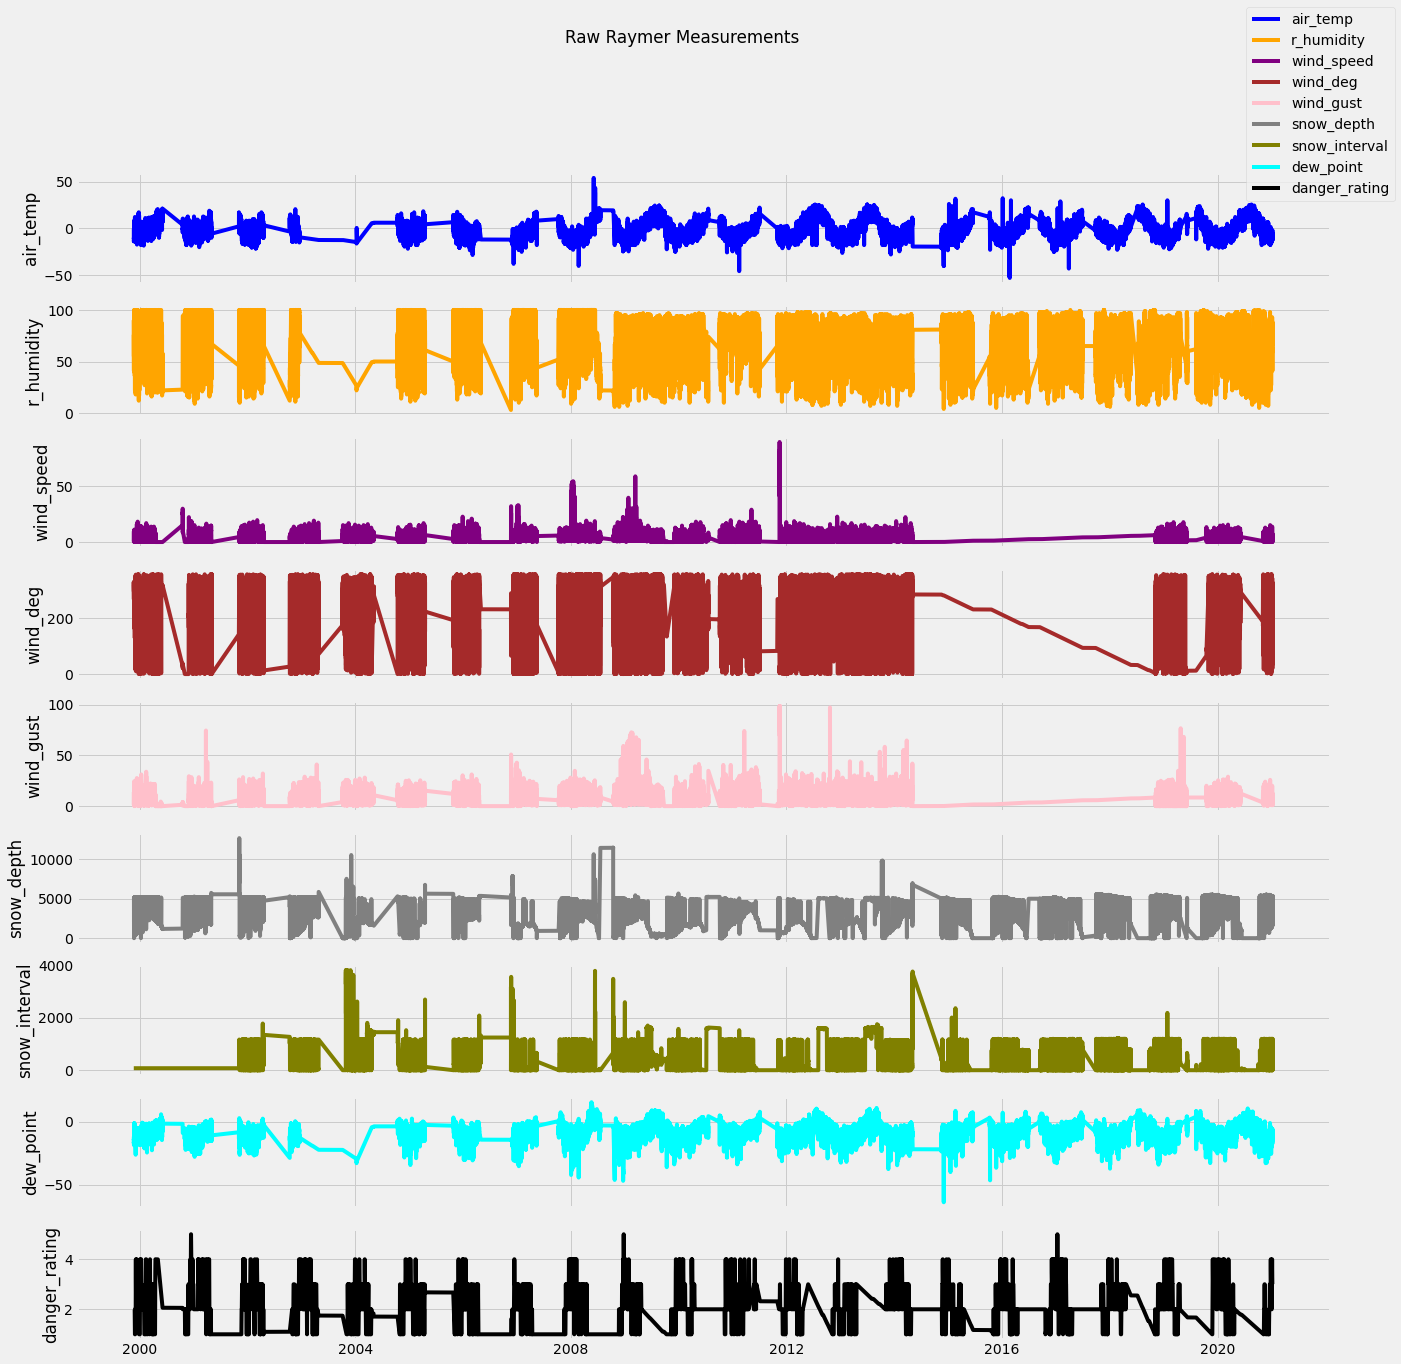

In [9]:
import matplotlib.pyplot as plt
import matplotlib.style as style
%matplotlib inline

def my_plot(df,title):

  style.use('fivethirtyeight')

  #Only plot float columns
  cols=[c for c in df if df[c].dtype==float]

  n=len(cols)
  color=['blue','orange','purple','brown','pink','gray','olive','cyan','black']

  fig,axs = plt.subplots(n,1,sharex=True,figsize=(20,20))

  for i,c in enumerate(cols):
    axs[i].plot(df[c],label=c,c=color[i])
    axs[i].set_ylabel(c)

  fig.suptitle(title)
  fig.legend()

my_plot(df_JHR,'Raw Raymer Measurements')

## **Feature Engineering**
Convert wind_cardinal to dummy variables. Normalize data using MinMaxScaler from scikit-learn. Finally, create 24-hr and 48-hr lag features and convert all danger_rating cols to Categorical.

In [10]:
#Convert wind to dummy
dummy_df=pd.get_dummies(df_JHR['wind_cardinal'],drop_first=True,dtype=float)
df_JHR=df_JHR.join(dummy_df)

In [11]:
#Normalize
from sklearn.preprocessing import MinMaxScaler

scaler=MinMaxScaler()
df_scaled=pd.DataFrame(index=df_JHR.index,data=scaler.fit_transform(df_JHR.loc[:,:'dew_point']))
df_scaled.columns='scaled_'+df_JHR.columns[:8]

In [12]:
#Organize new data
df_processed=df_scaled.join(df_JHR.loc[:,'wind_cardinal':])
df_processed.drop('wind_cardinal',axis=1,inplace=True)

In [13]:
#Sanity check
df_processed.describe()

,scaled_air_temp,scaled_r_humidity,scaled_wind_speed,scaled_wind_deg,scaled_wind_gust,scaled_snow_depth,scaled_snow_interval,scaled_dew_point,danger_rating,ENE,ESE,N,NE,NNE,NNW,NW,S,SE,SSE,SSW,SW,W,WNW,WSW
count,509134.000000,509134.000000,509134.000000,509134.000000,509134.000000,509134.000000,509134.000000,509134.000000,509134.000000,509134.000000,509134.000000,509134.000000,509134.000000,509134.000000,509134.000000,509134.000000,509134.000000,509134.000000,509134.000000,509134.000000,509134.000000,509134.000000,509134.000000,509134.000000
mean,0.467394,0.662868,0.041118,0.619463,0.071307,0.156189,0.042371,0.686424,2.043524,0.024496,0.007228,0.228496,0.010547,0.012765,0.042490,0.177116,0.096959,0.014941,0.038033,0.034857,0.028941,0.084626,0.154064,0.036537
std,0.081965,0.244212,0.032620,0.258185,0.051494,0.122186,0.096424,0.087084,0.746976,0.154585,0.084710,0.419864,0.102157,0.112258,0.201704,0.381768,0.295902,0.121317,0.191277,0.183418,0.167642,0.278325,0.361010,0.187621
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.406300,0.453608,0.020033,0.466667,0.040692,0.062374,0.000000,0.632604,1.485720,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.453173,0.721649,0.037737,0.707039,0.067187,0.142857,0.000000,0.692685,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.515609,0.876289,0.054758,0.833333,0.090495,0.203219,0.027905,0.745726,2.526923,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [14]:
#Create 24-hr and 48-hr lag features

#Interpolation caused invalid rating values. Round these values to closest int
df_processed.danger_rating=round(df_processed.danger_rating)

lag_24hr=df_processed['danger_rating'].shift(4*24).rename('lag_24hr')
lag_48hr=df_processed['danger_rating'].shift(4*48).rename('lag_48hr')

dummy_one=pd.get_dummies(df_processed.danger_rating,dtype=float)
dummy_two=pd.get_dummies(lag_24hr,dtype=float)
dummy_three=pd.get_dummies(lag_48hr,dtype=float)

dummy_one.columns=dummy_one.columns.astype(int).astype(str)
dummy_two.columns='lag_24hr '+dummy_two.columns.astype(int).astype(str)
dummy_three.columns='lag_48hr '+dummy_three.columns.astype(int).astype(str)

features=pd.concat([df_processed,dummy_two,dummy_three],axis=1)
features=features.iloc[4*48:,:]
features=features.drop(['danger_rating'],axis=1)

labels=dummy_one
labels=labels.iloc[4*48:,:]

## **Multicollinearity**

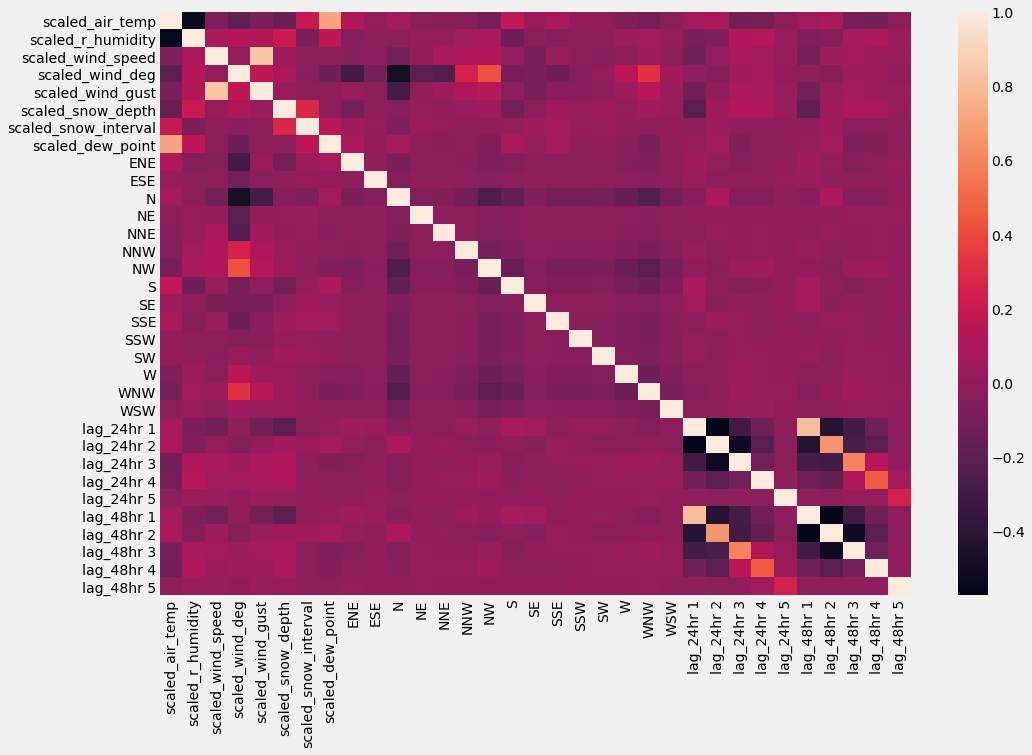

In [15]:
import seaborn as sns
corr=features.corr()
f, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(corr)



*   wind_deg can be inferred from all wind dummy variables. Drop wind_deg.
*   air_temp, r_humidity, and dew_pint are all closely correlated. Drop r_humidity and dew_point.

*   snow_interval and snow_depth are collinear. Drop snow_interval.
*   wind_speed and wind_gust are highly correlated. Drop wind_gust. Sustained winds are the primary factor in transporting snow to create wind slab avalanches.








In [16]:
features.drop(['scaled_wind_deg','scaled_r_humidity','scaled_dew_point','scaled_snow_interval','scaled_wind_gust'],axis=1,inplace=True)

## **Imbalanced Classification**
There are very few extreme danger ratings over the past 20 years. This will cause the model to poorly predict these ratings. Check all danger rating classes for imbalances and perform over-sampling.

In [17]:
labels.sum()/len(labels)

1    0.252993
2    0.492549
3    0.212895
4    0.041001
5    0.000562
dtype: float64

This is certainly imbalanced. Over-sampling will create noise. Instead I will alter class weights when I build the model.

## **LSTM Model**

Epoch 1/10
4072/4072 [==============================] - 13s 3ms/step - loss: 1.0047 - accuracy: 0.5992 - val_loss: 0.5081 - val_accuracy: 0.8464
Epoch 2/10
4072/4072 [==============================] - 11s 3ms/step - loss: 0.7542 - accuracy: 0.7321 - val_loss: 0.5039 - val_accuracy: 0.8466
Epoch 3/10
4072/4072 [==============================] - 11s 3ms/step - loss: 0.7444 - accuracy: 0.7327 - val_loss: 0.5010 - val_accuracy: 0.8499
Epoch 4/10
4072/4072 [==============================] - 11s 3ms/step - loss: 0.7396 - accuracy: 0.7318 - val_loss: 0.4986 - val_accuracy: 0.8540
Epoch 5/10
4072/4072 [==============================] - 11s 3ms/step - loss: 0.7361 - accuracy: 0.7316 - val_loss: 0.4964 - val_accuracy: 0.8563
Epoch 6/10
4072/4072 [==============================] - 11s 3ms/step - loss: 0.7332 - accuracy: 0.7324 - val_loss: 0.4945 - val_accuracy: 0.8571
Epoch 7/10
4072/4072 [==============================] - 11s 3ms/step - loss: 0.7306 - accuracy: 0.7330 - val_loss: 0.4929 - val_ac

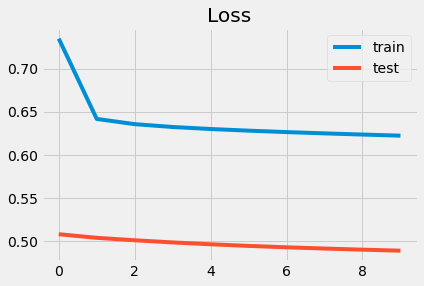

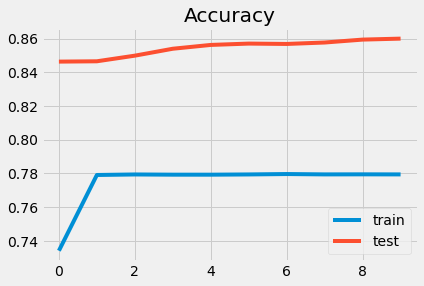

In [18]:
from keras.layers import LSTM,Dense
from keras.models import Sequential
from sklearn.metrics import confusion_matrix

def my_LSTM(cols):
  #Train/Test Split. Avoid Leakage.
  X_train=features[cols].iloc[:int(len(features)*.8),:]
  X_test=features[cols].iloc[int(len(features)*.8):,:]
  y_train=labels.iloc[:int(len(labels)*.8),:]
  y_test=labels.iloc[int(len(features)*.8):,:]

  #3D Format for Keras
  X_train = X_train.to_numpy().reshape((X_train.shape[0], 1, X_train.shape[1]))
  X_test = X_test.to_numpy().reshape((X_test.shape[0], 1, X_test.shape[1]))

  #Multiclass LSTM
  model=Sequential()
  model.add(LSTM(20,input_shape=(1,len(cols))))
  model.add(Dense(5, activation='softmax'))
  model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
  
  history=model.fit(X_train,y_train,epochs=10,batch_size=100,shuffle=False,validation_data=(X_test,y_test))

  #Confusion Matrix
  pred=model.predict(X_test)
  matrix = confusion_matrix(y_test.to_numpy().argmax(axis=1), pred.argmax(axis=1))
  print(matrix)

  #Plot Loss
  plt.title('Loss')
  plt.plot(history.history['loss'], label='train')
  plt.plot(history.history['val_loss'], label='test')
  plt.legend()
  plt.show();

  #Plot Accuracy
  plt.title('Accuracy')
  plt.plot(history.history['accuracy'], label='train')
  plt.plot(history.history['val_accuracy'], label='test')
  plt.legend()
  plt.show();

my_LSTM(features.columns)

Well....definetely not great that test accuracy is higher than train. Reconsider the test/train split. Also am sure about iid?

In [19]:
import xgboost
from sklearn.metrics import confusion_matrix

def my_XGB(cols):
  #Train/Test Split. Avoid Leakage.
  X_train=features[cols].iloc[:int(len(features)*.8),:]
  X_test=features[cols].iloc[int(len(features)*.8):,:]
  y_train=labels.iloc[:int(len(labels)*.8),:]
  y_test=labels.iloc[int(len(features)*.8):,:]

  #Back to Categorical
  y_train=y_train.idxmax(axis=1)
  y_test=y_test.idxmax(axis=1)

  # fit model no training data
  model = xgboost.XGBClassifier()
  model.fit(X_train, y_train)
  print(model)

  #Confusion Matrix
  pred=model.predict(X_test)
  matrix = confusion_matrix(y_test, pred)
  print(matrix)

  #accuracy
  accuracy = np.sum(y_test==pred)/len(y_test)
  print(accuracy)

my_XGB(features.columns)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)
[[27631  2293     0     0]
 [ 2195 43487  3307     0]
 [   98  3857 15803   340]
 [    0   452  1961   365]]
0.8575189853520518


## **Remarks**

Not finished. Stratify data based on teleconnection (el nino, la nina). Also don't predict too far out.